# Exercise 6: PyTorch Introduction with Logistic Regression

In [3]:
import ee

# Authenticate to the Earth Engine servers.
ee.Authenticate()
ee.Initialize()


Successfully saved authorization token.


make numpy arrays DONE! 
Normalise Image: DONE!

Surface Temprature added

Next 3 cells are Sentinel 2 images of Mount Etna!!! Map followed by test followed by loop!!!

In [1]:
import ee
ee.Initialize()
# Get the thumbnail URL
roi_display = ee.Geometry.Point(14.9995, 37.7489)

# Define a bounding box around the point of interest
roi_bbox = roi_display.buffer(1000)  # Adjust the buffer size as needed

collection = (ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
              .filterDate('2022-07-19', '2022-09-30')
              .filterBounds(roi_bbox)
              .filter(ee.Filter.contains('.geo',roi_bbox))
              .sort('CLOUDY_PIXEL_PERCENTAGE')
              .sort('system:time_start', True))

# Get a list of images in the collection
image = collection.first()
print(collection.size().getInfo())
import geemap
# Create a geemap Map centered on Mount Etna
my_map = geemap.Map(center=[37.7489, 14.9995], zoom=12)

# Add the Landsat 8 image to the map
my_map.add_ee_layer(image, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 2000}, 'Landsat 8')
my_map


30


Map(center=[37.7489, 14.9995], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

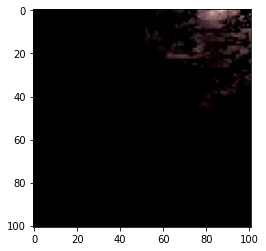

In [52]:
from PIL import Image
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
import ee

# Initialize Earth Engine
ee.Initialize()

roi_display = ee.Geometry.Point(14.9995, 37.7489)

# Define a bounding box around the point of interest
roi_bbox = roi_display.buffer(1500)  # Adjust the buffer size as needed

collection = (ee.ImageCollection('COPERNICUS/S2_HARMONIZED')
              .filterDate('2022-01-19', '2022-04-30')
              .filterBounds(roi_bbox)
              .sort('CLOUDY_PIXEL_PERCENTAGE')) #Notice, you can drop the images with many clouds!!
              #.sort('system:time_start', False))

my_image = collection.first()

# Specify visualization parameters
vis_params = {
    'bands': ['B4', 'B3', 'B2'],
    'min': 5000,
    'max': 12000,
    #'gamma': 1.4,
}

# Visualize the image
img = my_image.visualize(**vis_params)

# Get the thumbnail URL
thumb_url = img.getThumbURL({'region': roi_bbox.getInfo()['coordinates'], 'scale': 30})

# Open the image from URL
img = Image.open(urllib.request.urlopen(thumb_url))

# Convert to NumPy array
false_color_array = np.array(img)[:, :, :3]

# Plot the image
plt.imshow(false_color_array)
plt.show()


16


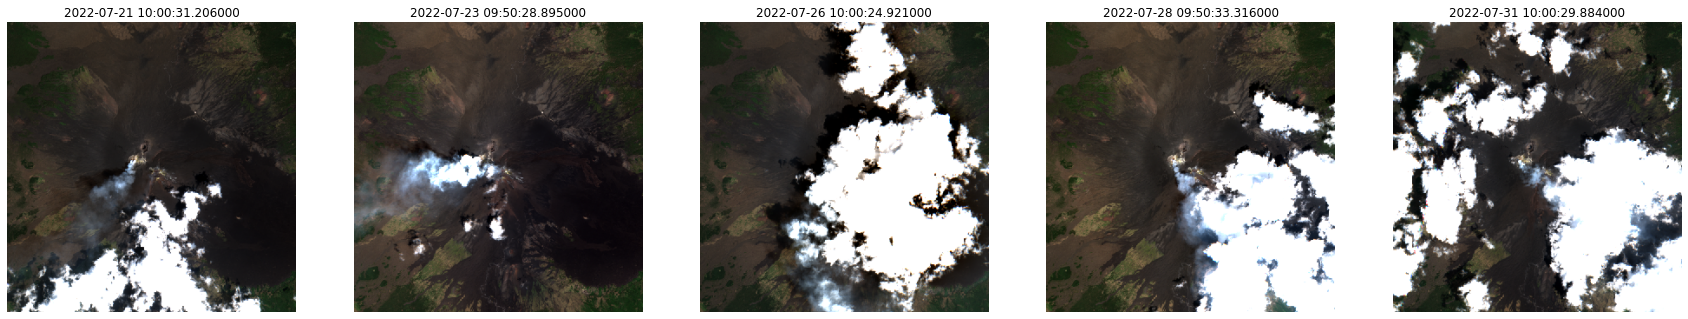

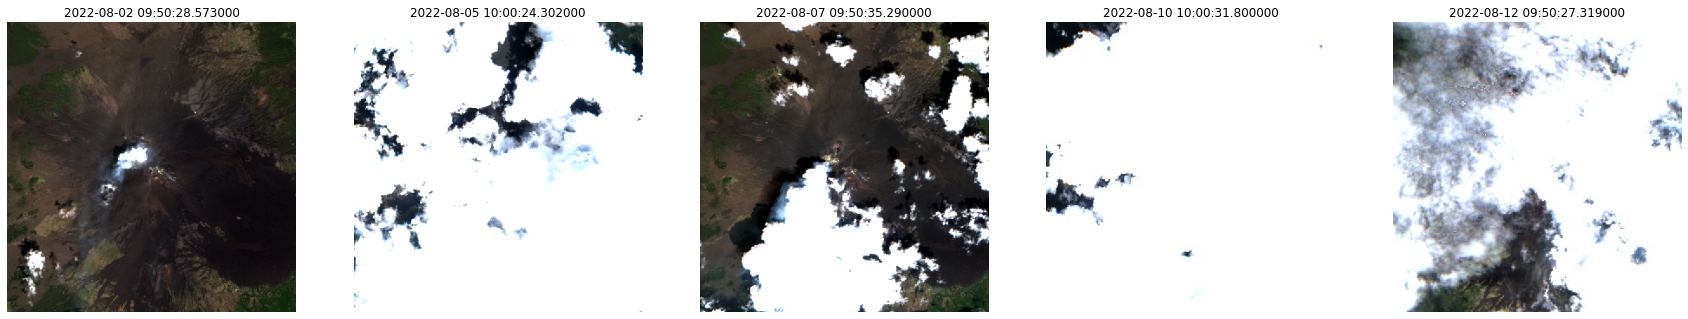

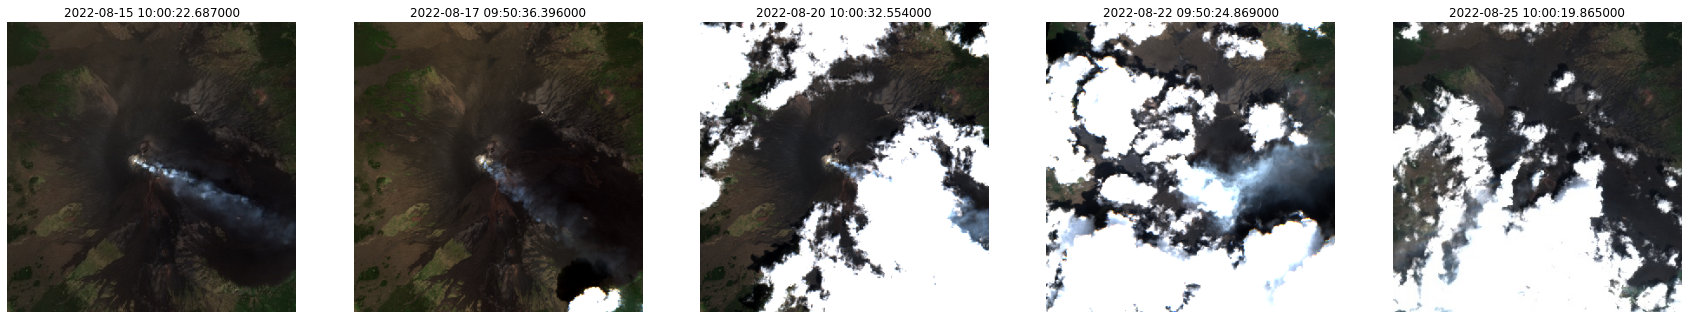

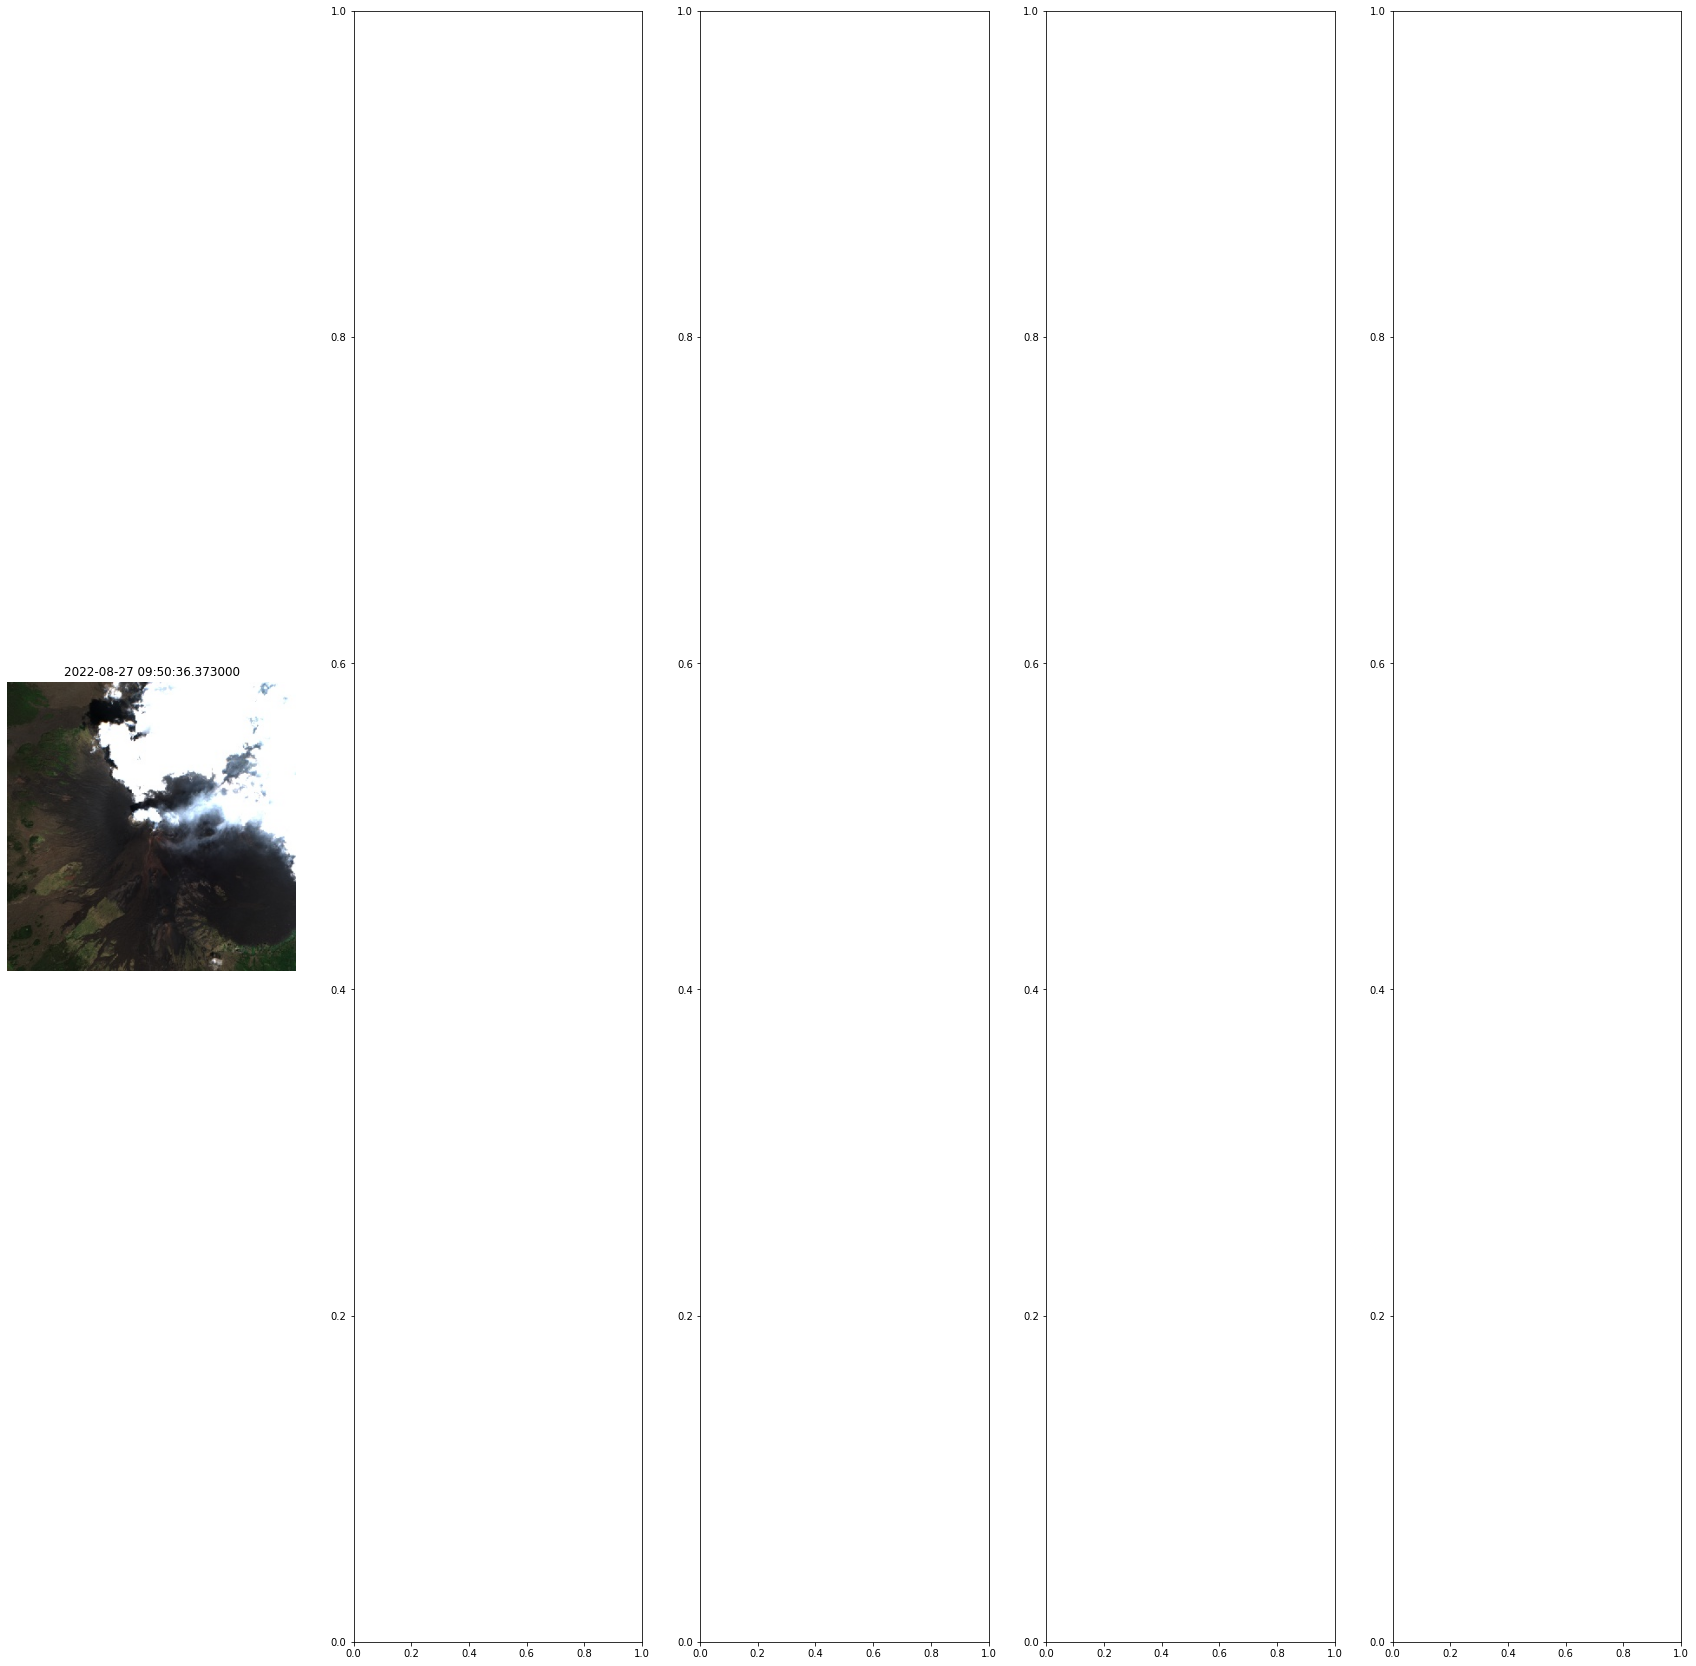

In [108]:
import ee
import urllib.request
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from datetime import datetime
from skimage import exposure
import numpy as np
from PIL import Image


###
def get_normalized_image(image, percentiles=(2, 98)):
    """
    Rescale image to values between 0 to 255 (capping outlier values) 
    
    Parameters
    ==================
    image: Numpy array
        Image numpy array with shape (height, width, num_bands)
    
    percentiles: tuple
        Tuple of min and max percentiles to cap outlier values
    
    Returns
    ==================
    output: Numpy array
        Normalized image numpy array
    
    """
    output = np.zeros_like(image)
    for k in range(image.shape[2]): # for each band
        p_min, p_max = np.percentile(image[:, :, k], percentiles)
        output[:, :, k] = exposure.rescale_intensity(image[:, :, k], 
                            in_range=(p_min, p_max), out_range=(0, 255))
    return output.astype(np.uint8)
###


# Initialize Earth Engine
ee.Initialize()


roi_display = ee.Geometry.Point(14.9995, 37.7489)

# Define a bounding box around the point of interest
roi_bbox = roi_display.buffer(5000)  # Adjust the buffer size as needed

collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
              .filterDate('2022-07-19', '2022-08-30')
              .filterBounds(roi_bbox)
              .filter(ee.Filter.contains('.geo',roi_bbox))
              .sort('CLOUDY_PIXEL_PERCENTAGE') #Notice, you can drop the images with many clouds!!
              .sort('system:time_start', True))

# Get a list of images in the collection
image = collection.first()
print(collection.size().getInfo())

# Get a list of images in the collection
image_list = collection.toList(collection.size())

# Specify the number of images to plot at a time
images_per_iteration = 5

# Calculate the number of iterations needed
num_iterations = (collection.size().getInfo() + images_per_iteration - 1) // images_per_iteration


# Display each image in real-time
for iteration in range(num_iterations):
    

    # Set the size of each subplot
    fig, axs = plt.subplots(1, images_per_iteration, figsize=(30, 30))
    
    # Loop through the images for the current iteration
    for i in range(images_per_iteration):
        # Get the index of the current image
        index = iteration * images_per_iteration + i
        
        # Check if the index is within the collection size
        if index < collection.size().getInfo():
            # Get the image from the list
            image = ee.Image(image_list.get(index)) #.clip(roi) clips only part we are interested in but still keeps black surrounding

            viz = image.visualize(bands=["B4", "B3", "B2"],
                                                    min = 0,
                                                    max = 3000) #seems to show the true image perhaps there are better paraemeters but not here!

            # Specify the scale for the thumbnail (adjust as needed)
            scale = 30 #30m per pixel ----> If you want to change the zoom "rectangle size" you may need to adjust the scale otherwise can be pixel dense or sparse

            # Get the thumbnail URL
            thumb_url = viz.getThumbURL({'region': roi_bbox.getInfo()['coordinates'], 'scale': 30})

            # Open the URL and read the image using Pillow
            img = Image.open(urllib.request.urlopen(thumb_url))

            # Convert the Pillow image to a NumPy array
            false_color_array = np.array(img)[:, :, :3] #Exclude the alpha channel from Earth Engine (Tranparency)
            #print(f"False Color Array Shape: {false_color_array.shape}")

            #false_color_array_normalised = get_normalized_image(false_color_array, percentiles=(10, 90)) #not as good as min=5000, max=12000

            # Get the date and time of the image
            date_time = ee.Date(image.get('system:time_start'))
            date_time = date_time.format('YYYY-MM-dd').getInfo()
            #print(date_time)

            # more specific included HH:MM:SS
            acquisition_time = image.get('system:time_start').getInfo()
            acquisition_time = datetime.utcfromtimestamp(acquisition_time / 1000.0)
            #print(f"Acquisition Time: {acquisition_time}")

          
            # Display the image in the subplot
            ax = axs[i]
            ax.set_title(acquisition_time)
            ax.axis('off')
            ax.imshow(false_color_array) #Only normalise when you remove min and max args
        else:
            break
    plt.show()


    # Store/Save the original image "non-normalised" then store the normalised image or actually later load the original image and then normalise then save. Here you
    # should not worry too much about normalisation, just get the orig image and store it.
    # FOUND IT!!!! NEED TO USE SO CALLED HISTOGRAM ENHANCEMENTS!!!!!!!!!!!!!!!!!!!!!!!!!!! TODO!

In [2]:
import ee
import urllib.request
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from datetime import datetime
from skimage import exposure
import numpy as np
from PIL import Image


###
def get_normalized_image(image, percentiles=(2, 98)):
    """
    Rescale image to values between 0 to 255 (capping outlier values) 
    
    Parameters
    ==================
    image: Numpy array
        Image numpy array with shape (height, width, num_bands)
    
    percentiles: tuple
        Tuple of min and max percentiles to cap outlier values
    
    Returns
    ==================
    output: Numpy array
        Normalized image numpy array
    
    """
    output = np.zeros_like(image)
    for k in range(image.shape[2]): # for each band
        p_min, p_max = np.percentile(image[:, :, k], percentiles)
        output[:, :, k] = exposure.rescale_intensity(image[:, :, k], 
                            in_range=(p_min, p_max), out_range=(0, 255))
    return output.astype(np.uint8)
###



# Initialize Earth Engine
ee.Initialize()

# Define the region of interest (ROI)
margin = 2
roi = ee.Geometry.Polygon([
    [14.9995 - margin, 37.7489 - margin],
    [14.9995 - margin, 37.7489 + margin],
    [14.9995 + margin, 37.7489 + margin],
    [14.9995 + margin, 37.7489 - margin]
], None, False)#.buffer(200000) #Adding buffer will make you further away from the polygon

margin = 0.18
roi_contained = ee.Geometry.Polygon([
    [14.9995 - margin, 37.7489 - margin],
    [14.9995 - margin, 37.7489 + margin],
    [14.9995 + margin, 37.7489 + margin],
    [14.9995 + margin, 37.7489 - margin]
], None, False)

# margin = 3
#roi_point = ee.Geometry.Point(14.9995, 37.7489)#There must be a better way!!! I keep losing the volcano in the images

# Create an image collection (Landsat 8) and filter based on the ROI and date.
collection = (ee.ImageCollection('LANDSAT/LE07/C01/T1')
              .filterDate('2012-01-01', '2012-12-31')
              .filterBounds(roi)
              .filter(ee.Filter.contains('.geo',roi_contained))
              .sort('CLOUDY_PIXEL_PERCENTAGE')
              .sort('system:time_start', False))  # Sort by date in descending order

print(collection.size().getInfo())
# Get a list of images in the collection
image_list = collection.toList(collection.size())

# Specify the number of images to plot at a time
images_per_iteration = 5

# Calculate the number of iterations needed
num_iterations = (collection.size().getInfo() + images_per_iteration - 1) // images_per_iteration


# Display each image in real-time
for iteration in range(num_iterations):
    

    # Set the size of each subplot
    fig, axs = plt.subplots(1, images_per_iteration, figsize=(30, 30))
    
    # Loop through the images for the current iteration
    for i in range(images_per_iteration):
        # Get the index of the current image
        index = iteration * images_per_iteration + i
        
        # Check if the index is within the collection size
        if index < collection.size().getInfo():
            # Get the image from the list
            image = ee.Image(image_list.get(index)) #.clip(roi) clips only part we are interested in but still keeps black surrounding

            false_color_composite = image.visualize(bands=["B3", "B2", "B1"])#,
                                                    #min = 5000,
                                                    #max = 12000) #seems to show the true image perhaps there are better paraemeters but not here!

            # Specify the scale for the thumbnail (adjust as needed)
            scale = 50 #30m per pixel ----> If you want to change the zoom "rectangle size" you may need to adjust the scale otherwise can be pixel dense or sparse

            # Get the thumbnail URL
            thumb_url = false_color_composite.getThumbURL({'region': roi_contained, 
                                                           'scale': scale})

            # Open the URL and read the image using Pillow
            img = Image.open(urllib.request.urlopen(thumb_url))
            

            # Convert the Pillow image to a NumPy array
            false_color_array = np.array(img)[:, :, :3] #Exclude the alpha channel from Earth Engine (Tranparency)
            #print(f"False Color Array Shape: {false_color_array.shape}")

            false_color_composite_normalised = get_normalized_image(false_color_array) #not as good as min=5000, max=12000

            # Get the date and time of the image
            date_time = image.get('DATE_ACQUIRED').getInfo()


            # Get the thumbnail URL
            #thumb_url = false_color_composite.getThumbURL({'region': roi, 'scale': scale})

            # Open the URL and read the image using Pillow
            #img = Image.open(urllib.request.urlopen(thumb_url))

            acquisition_time = image.get('system:time_start').getInfo()
            #print(f"Acquisition Time: {acquisition_time}")
            acquisition_time = datetime.utcfromtimestamp(acquisition_time / 1000.0)
            #print(f"Acquisition Time: {acquisition_time}")

          
            # Display the image in the subplot
            ax = axs[i]
            ax.set_title(date_time)
            #ax.axis('off')
            ax.imshow(false_color_composite_normalised) #Only normalise when you remove min and max args
        else:
            break
    plt.show()

RefreshError: ('invalid_grant: Token has been expired or revoked.', {'error': 'invalid_grant', 'error_description': 'Token has been expired or revoked.'})

22


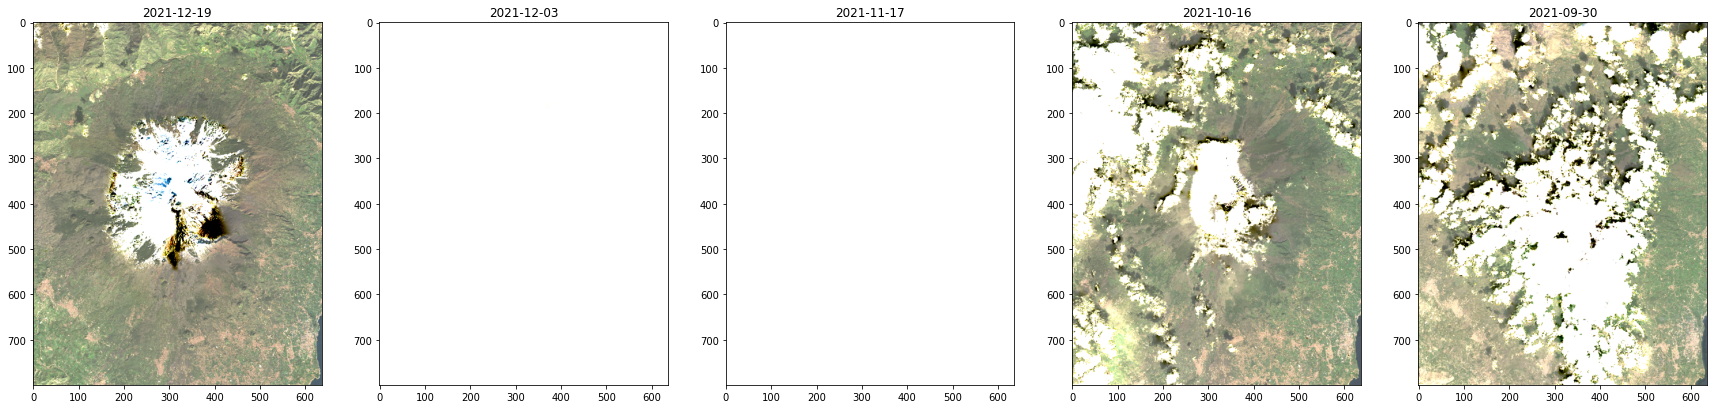

KeyboardInterrupt: 

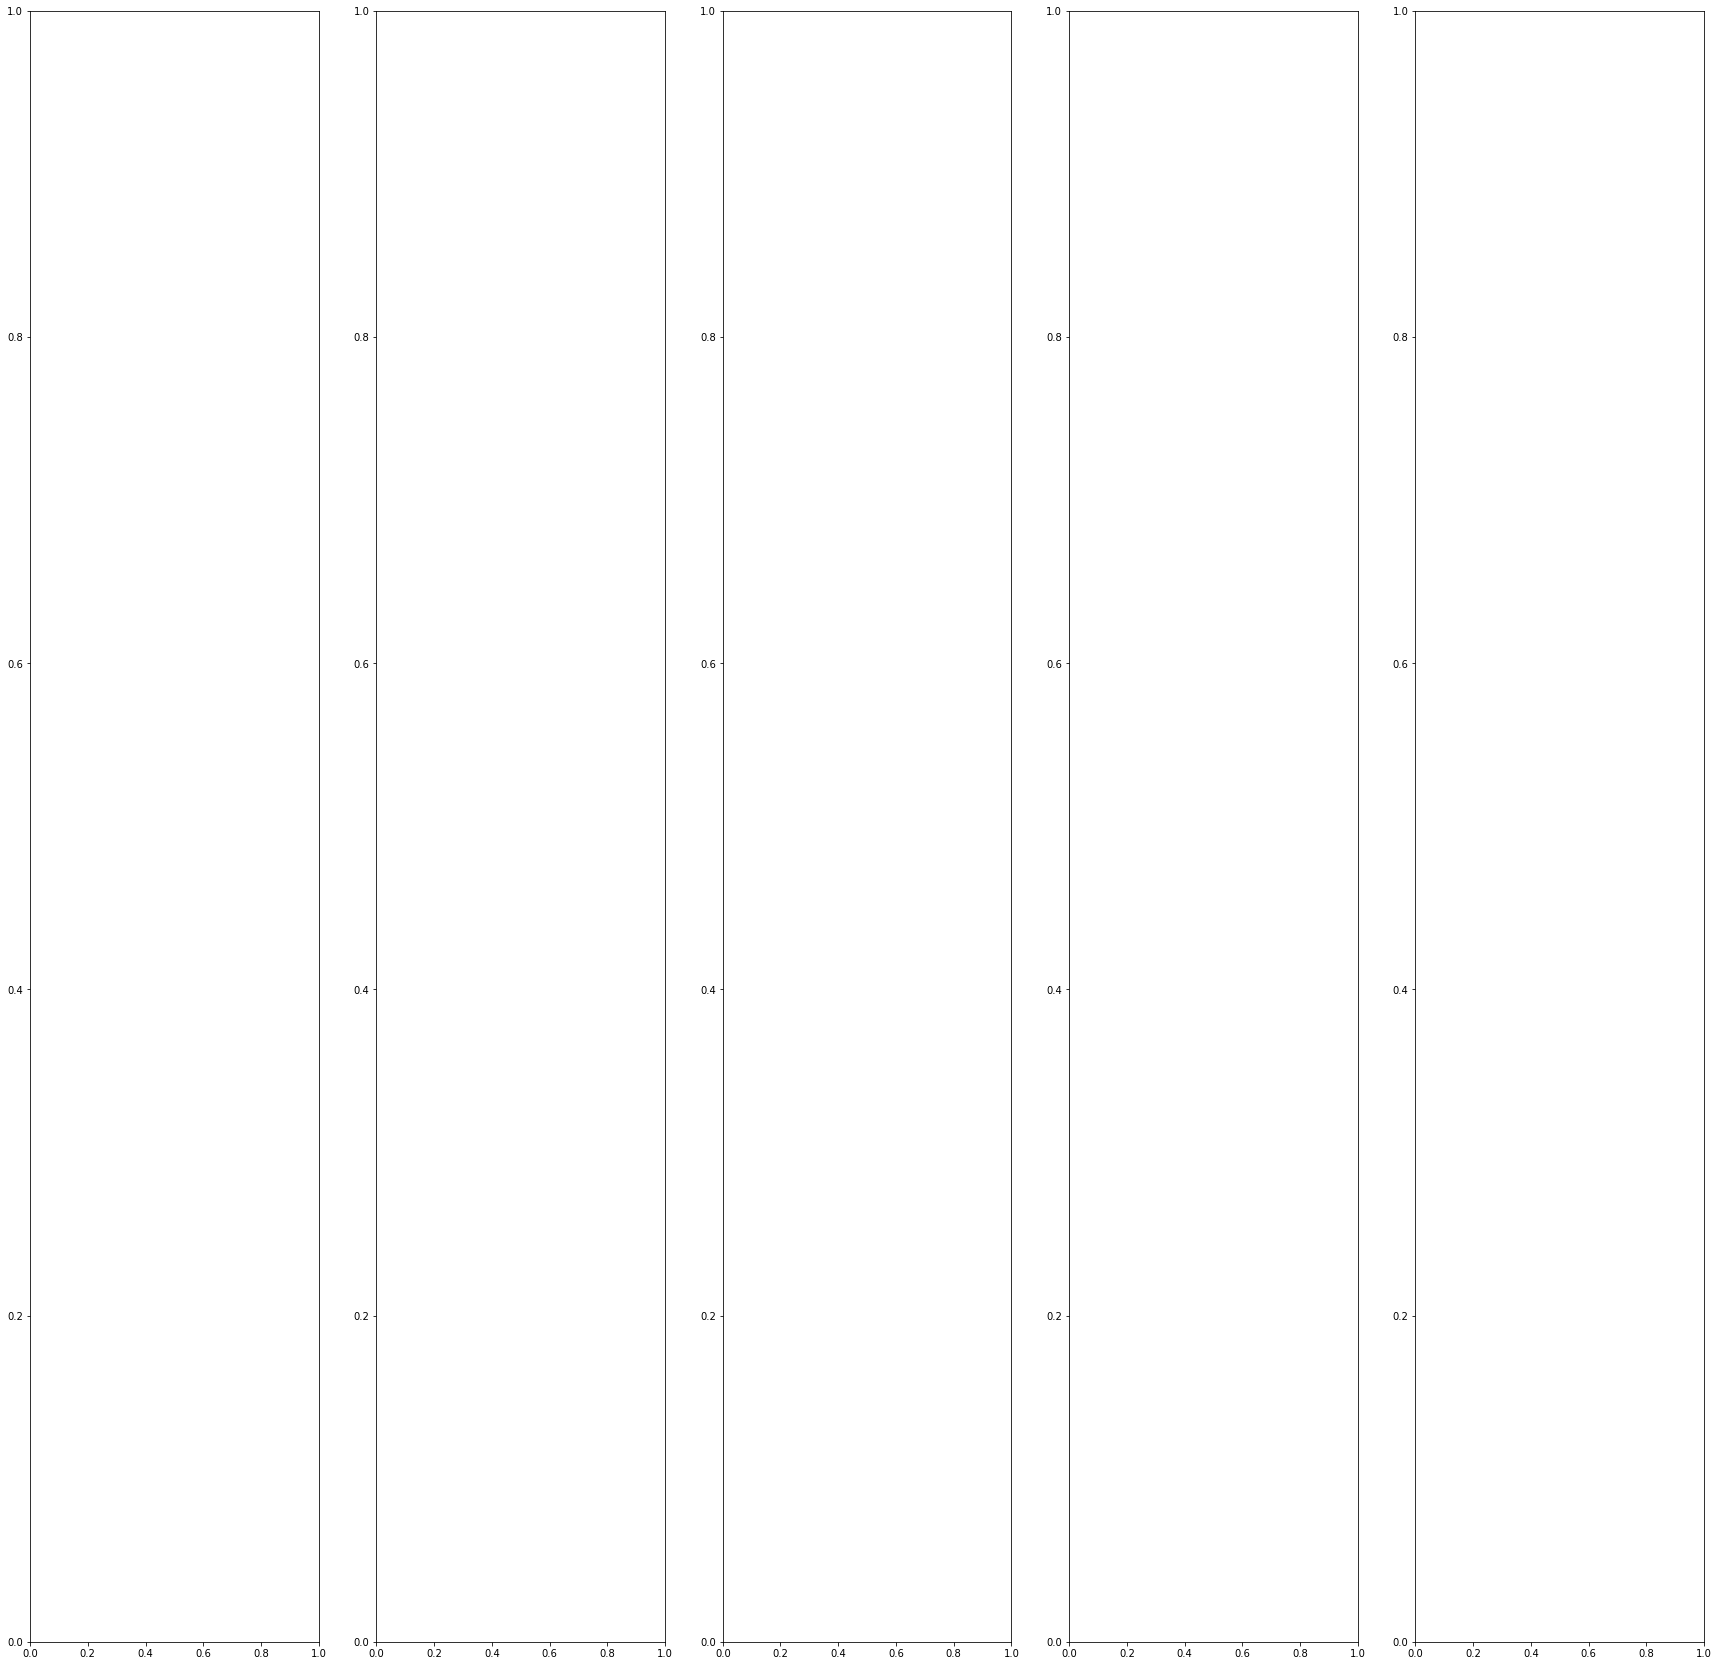

In [71]:
import ee
import urllib.request
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from datetime import datetime
from skimage import exposure
import numpy as np
from PIL import Image


###
def get_normalized_image(image, percentiles=(2, 98)):
    """
    Rescale image to values between 0 to 255 (capping outlier values) 
    
    Parameters
    ==================
    image: Numpy array
        Image numpy array with shape (height, width, num_bands)
    
    percentiles: tuple
        Tuple of min and max percentiles to cap outlier values
    
    Returns
    ==================
    output: Numpy array
        Normalized image numpy array
    
    """
    output = np.zeros_like(image)
    for k in range(image.shape[2]): # for each band
        p_min, p_max = np.percentile(image[:, :, k], percentiles)
        output[:, :, k] = exposure.rescale_intensity(image[:, :, k], 
                            in_range=(p_min, p_max), out_range=(0, 255))
    return output.astype(np.uint8)
###



# Initialize Earth Engine
ee.Initialize()

# Define the region of interest (ROI)
margin = 2
roi = ee.Geometry.Polygon([
    [14.9995 - margin, 37.7489 - margin],
    [14.9995 - margin, 37.7489 + margin],
    [14.9995 + margin, 37.7489 + margin],
    [14.9995 + margin, 37.7489 - margin]
], None, False)#.buffer(200000) #Adding buffer will make you further away from the polygon

margin = 0.18
roi_contained = ee.Geometry.Polygon([
    [14.9995 - margin, 37.7489 - margin],
    [14.9995 - margin, 37.7489 + margin],
    [14.9995 + margin, 37.7489 + margin],
    [14.9995 + margin, 37.7489 - margin]
], None, False)

# margin = 3
#roi_point = ee.Geometry.Point(14.9995, 37.7489)#There must be a better way!!! I keep losing the volcano in the images

# Create an image collection (Landsat 8) and filter based on the ROI and date.
collection = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
              .filterDate('2021-01-01', '2021-12-31')
              .filterBounds(roi)
              .filter(ee.Filter.contains('.geo',roi_contained))
              .sort('CLOUDY_PIXEL_PERCENTAGE')
              .sort('system:time_start', False))  # Sort by date in descending order

print(collection.size().getInfo())
# Get a list of images in the collection
image_list = collection.toList(collection.size())

# Specify the number of images to plot at a time
images_per_iteration = 5

# Calculate the number of iterations needed
num_iterations = (collection.size().getInfo() + images_per_iteration - 1) // images_per_iteration


# Display each image in real-time
for iteration in range(num_iterations):
    

    # Set the size of each subplot
    fig, axs = plt.subplots(1, images_per_iteration, figsize=(30, 30))
    
    # Loop through the images for the current iteration
    for i in range(images_per_iteration):
        # Get the index of the current image
        index = iteration * images_per_iteration + i
        
        # Check if the index is within the collection size
        if index < collection.size().getInfo():
            # Get the image from the list
            image = ee.Image(image_list.get(index)) #.clip(roi) clips only part we are interested in but still keeps black surrounding

            false_color_composite = image.visualize(bands=["SR_B4", "SR_B3", "SR_B2"],
                                                    min = 5000,
                                                    max = 12000) #seems to show the true image perhaps there are better paraemeters but not here!

            # Specify the scale for the thumbnail (adjust as needed)
            scale = 50 #30m per pixel ----> If you want to change the zoom "rectangle size" you may need to adjust the scale otherwise can be pixel dense or sparse

            # Get the thumbnail URL
            thumb_url = false_color_composite.getThumbURL({'region': roi_contained, 
                                                           'scale': scale})

            # Open the URL and read the image using Pillow
            img = Image.open(urllib.request.urlopen(thumb_url))
            

            # Convert the Pillow image to a NumPy array
            false_color_array = np.array(img)[:, :, :3] #Exclude the alpha channel from Earth Engine (Tranparency)
            #print(f"False Color Array Shape: {false_color_array.shape}")

            #false_color_composite_normalised = get_normalized_image(false_color_array) not as good as min=5000, max=12000

            # Get the date and time of the image
            date_time = image.get('DATE_ACQUIRED').getInfo()


            # Get the thumbnail URL
            #thumb_url = false_color_composite.getThumbURL({'region': roi, 'scale': scale})

            # Open the URL and read the image using Pillow
            #img = Image.open(urllib.request.urlopen(thumb_url))

            acquisition_time = image.get('system:time_start').getInfo()
            #print(f"Acquisition Time: {acquisition_time}")
            acquisition_time = datetime.utcfromtimestamp(acquisition_time / 1000.0)
            #print(f"Acquisition Time: {acquisition_time}")

          
            # Display the image in the subplot
            ax = axs[i]
            ax.set_title(date_time)
            #ax.axis('off')
            ax.imshow(false_color_array) #Only normalise when you remove min and max args
        else:
            break
    plt.show()

Below code stores picture of region at particular time

In [68]:
# TRY INFRARED AGAIN--- Possibly works
# Define the region of interest (ROI)
roi = ee.Geometry.Point(14.9995, 37.7489)
roi = ee.Geometry.Rectangle(
    coords=[roi.getInfo()['coordinates'][0] - 0.05, roi.getInfo()['coordinates'][1] - 0.05,
            roi.getInfo()['coordinates'][0] + 0.05, roi.getInfo()['coordinates'][1] + 0.05]
)

# Create an image collection (Landsat 8) and filter based on the ROI and date.
collection = (ee.ImageCollection('LANDSAT/LC08/C01/T1')
              .filterBounds(roi)
              .filterDate('2021-01-01', '2022-12-31')
              .sort('CLOUDY_PIXEL_PERCENTAGE'))

# Get the first (least cloudy) image from the collection.
my_image = collection.first()

# Select the near-infrared band (B5) for export
infrared_band = my_image.select(['B5'])

# Export the image to Google Drive
task = ee.batch.Export.image.toDrive(
    image=infrared_band,
    description='infrared_export',
    scale=30,  # corresponds to 30m by 30m each pixel. (Highest accurary with Landsat 8)
    region=roi,
    fileFormat='GeoTIFF',  # Change to 'PNG' if you want a PNG
)

# Start the export task
task.start()

# Wait for the task to complete
import time
while task.active():
    time.sleep(30)

# Check if the export was successful
if task.status()['state'] == 'COMPLETED':
    print('Export completed successfully.')
else:
    print('Export failed.')

Export completed successfully.


Below Code shows map of region at particular time it adds layer from satellite image at that time

In [1]:
from IPython.display import display, Image
import geemap
import ee

ee.Initialize()

# Define the region of interest (ROI)
roi = ee.Geometry.Point(14.9995, 37.7489)
roi = ee.Geometry.Rectangle(
    coords=[roi.getInfo()['coordinates'][0] - 0.05, roi.getInfo()['coordinates'][1] - 0.05,
            roi.getInfo()['coordinates'][0] + 0.05, roi.getInfo()['coordinates'][1] + 0.05]
)

# Define the date of interest
start_date = '2020-11-01'
end_date = '2022-11-02'

# Create an image collection (Landsat 8) and filter based on the ROI and date.
collection = (ee.ImageCollection('CSIC/SPEI/2_8') #WORLDVIEW/2' #LANDSAT/LC08/C01/T1
              .filterBounds(roi)
              .filterDate('2021-01-01', '2022-12-31')
              .sort('CLOUDY_PIXEL_PERCENTAGE'))

# Get the first (least cloudy) image from the collection.
my_image = collection.first()

# Create a false-color composite emphasizing the near-infrared band
false_color_composite = my_image.visualize(
    bands=["B5", "B4", "B3"],  # Near-infrared, Red, Green
    #min=[0,0,0],
    #max=[3000,3000,3000],
    #gamma=1.4
)

# Specify the scale for the thumbnail (adjust as needed)

# Create a geemap Map centered on Mount Etna
my_map = geemap.Map(center=[37.7489, 14.9995], zoom=13)

# Add the Landsat 8 image to the map
my_map.add_ee_layer(my_image)


# Display the map
my_map

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_doiqkQG3NJ1t8IS?source=API


Map(center=[37.7489, 14.9995], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

In [13]:
print(collection.size().getInfo())

45


In [61]:
# Define a region of interest (ROI) using a bounding box (coordinates).
roi = ee.Geometry.Rectangle([37.9, 13.1, 37.74, 15.1]) #[37.75, 14.9, 37.74, 15.1]


###try: WORKS
roi = ee.Geometry.Point(14.9995, 37.7489)
roi = buffered_etna = ee.Geometry.Rectangle(
    coords=[roi.getInfo()['coordinates'][0]-0.05, roi.getInfo()['coordinates'][1]-0.05,
            roi.getInfo()['coordinates'][0]+0.05, roi.getInfo()['coordinates'][1]+0.05]
)
###ed try

# Create an image collection (Landsat 8) and filter based on the ROI and date.
collection = (ee.ImageCollection('LANDSAT/LC08/C01/T1')
              .filterBounds(roi)
              .filterDate('2021-01-01', '2022-12-31')
              .sort('CLOUDY_PIXEL_PERCENTAGE'))

# Get the first (least cloudy) image from the collection.
my_image = collection.first()

image_byte = my_image.visualize().toByte()

# Export the image to Google Drive
task = ee.batch.Export.image.toDrive(
  image=image_byte,
  description='my_export',
  scale=30,  # Adjust the scale according to your needs
  region=roi,
  fileFormat='GeoTIFF',  # Change to 'PNG' if you want a PNG
)

# Start the export task
task.start()

# Wait for the task to complete
import time
while task.active():
    time.sleep(30)

# Check if the export was successful
if task.status()['state'] == 'COMPLETED':
    print('Export completed successfully.')
else:
     print('Export failed.')

Export completed successfully.
